В рамках данного проекта мы построим простую (возможно сложную) модель банковского скоринг.  
Что это такое?  
Кредитный скоринг — система оценки кредитоспособности лица, основанная на численных статистических методах.  
Иными словами мы знаем какую-то информацию о клиентах и на её основе принимаем решение о выдаче кредита или отказе клиенту.  

Импортируем необходимые нам для работы с данными и моделями библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

Загружаем нашу выборку для обучения модели

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

73799 строк
Все поля кроме education заполненены  
Описание полей:
- client_id - идентификатор клиента
- app_date - дата заявки
- education -	уровень образования  
- sex -пол заёмщика  
- age - возраст заёмщика  
- car - флаг наличия автомобиля  
- car_type - флаг автомобиля-иномарки  
- decline_app_cnt - количество отказанных прошлых заявок  
- good_work - флаг наличия «хорошей» работы  
- score_bki - балл по данным БКИ  
- bki_request_cnt - количество запросов в БКИ  
- region_rating - рейтинг региона  
- home_address - категоризатор домашнего адреса  
- work_address - категоризатор рабочего адреса  
- income - доход заёмщика 
- sna - Social Network Analysis (уровень соц связей клиента)  
- first_time - На сколько давно клиент обращался первый раз
- foreign_passport - наличие загранпаспорта  
- default - Предоставление кредита

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

В тестовой выборке 36349 строк и также есть пропуски с поле education

In [5]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


В submission у нас 24354 строки
Первое, что нам необходимо сделать - заполнить пропуски

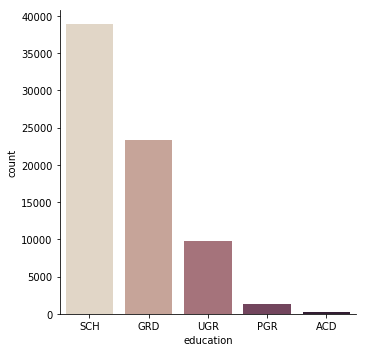

In [6]:
sns.catplot(x="education", kind="count", palette="ch:.25", data=train_df)

Видим, что большинство клиентов имеет образование SCH. Учитывая небольшое количество пропусков можем для всех применить значение SCH

In [7]:
train_df['education'] = train_df['education'].fillna('SCH')
test_df['education'] = test_df['education'].fillna('SCH')

Проверяем заполненность пропусков

In [8]:
print(train_df.isna().sum())
print(test_df.isna().sum())

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64
client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
dtype: int64


Поделим признаки на количественные, категориальные и бинарные
У нас ещё есть признак app_date, который можно будет как-то применить,но подумаем об этом потом

In [9]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'work_address', 'home_address']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'income', 'region_rating', 'bki_request_cnt', 'sna', 'first_time']

In [10]:
train_df['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Наша выборка очень сильно превалирует в сторону клиентов с признаком no default.  
Нам нужно её выровнять

In [11]:
train_d0 = train_df.query('default == 0')
train_d1 = train_df.query('default == 1')
koeff = int(len(train_d0)/len(train_d1))
for i in range(koeff):
    train_df = train_df.append(train_d1).reset_index(drop=True)

In [12]:
train_df['default'].value_counts()

1    65604
0    64427
Name: default, dtype: int64

Построим боксплоты для анализа количественный признаков

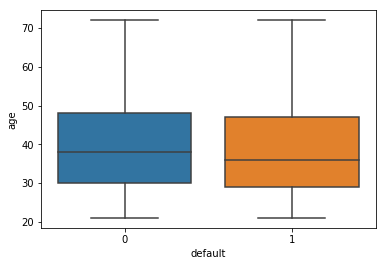

In [13]:
sns.boxplot(x=train_df.default, y=train_df.age)

Из диаграммы видим, что в среднем клиенты, которым был выдан кредит старше, чем те, которым было отказано

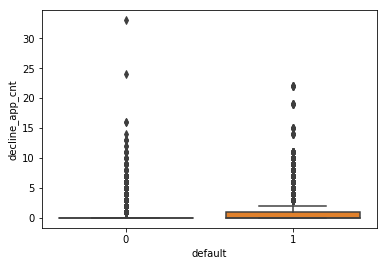

In [14]:
sns.boxplot(x=train_df.default, y=train_df.decline_app_cnt)

In [15]:
train_df['decline_app_cnt'].value_counts()

0     101444
1      17859
2       6074
3       2385
4       1134
5        423
6        317
7        132
8         79
9         78
10        41
11        27
14         8
15         7
19         7
22         7
13         3
12         2
16         2
24         1
33         1
Name: decline_app_cnt, dtype: int64

Количество отклоненных заявок у чаще всего ведет к отказу.

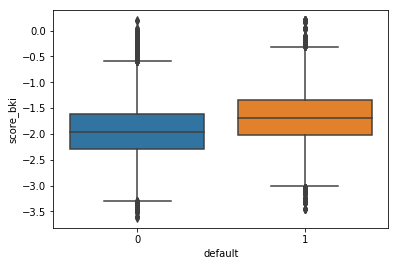

In [16]:
sns.boxplot(x=train_df.default, y=train_df.score_bki)

Рейтинг БКИ. Похоже, что чем ниже рейтинг - тем выше вероятность одобрения заявки. присутствую выбросы.

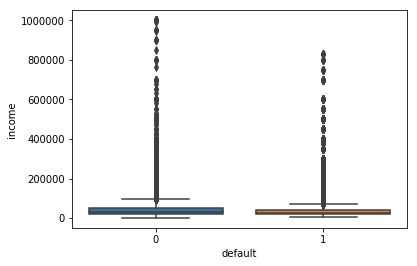

In [17]:
sns.boxplot(x=train_df.default, y=train_df.income)

Логично, что чем выше доход, тем вероятнее одобрение заявки.

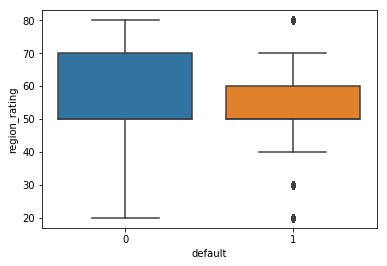

In [18]:
sns.boxplot(x=train_df.default, y=train_df.region_rating)

Похоже, что чем выше рейтинг - тем более вероятно обобрение кредита

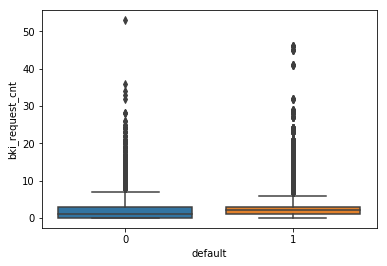

In [19]:
sns.boxplot(x=train_df.default, y=train_df.bki_request_cnt)

In [20]:
train_df['bki_request_cnt'].value_counts()

1     31302
0     30427
2     24669
3     17215
4     10733
5      6592
6      3378
7      1656
8      1096
9       647
10      465
11      464
12      366
13      250
14      182
15      144
16       89
18       70
17       61
19       36
20       33
21       30
24       29
23       25
27       14
28       10
32        8
46        7
29        7
41        7
45        7
22        4
25        2
26        2
33        1
34        1
36        1
53        1
Name: bki_request_cnt, dtype: int64

Чем меньше было запросов - тем больше вероятность одобрения

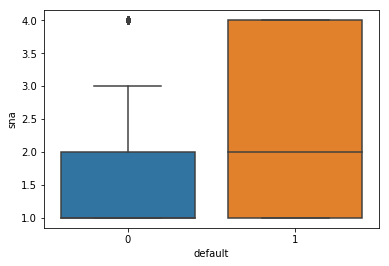

In [21]:
sns.boxplot(x=train_df.default, y=train_df.sna)

явно, чем ниже sna, тем больше вероятность одобрения заявки

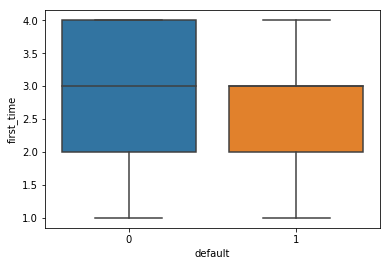

In [22]:
sns.boxplot(x=train_df.default, y=train_df.first_time) 

Есть несколько признаков, где явно наблюдаются выбросы. Это признаки
И так, нам надо избавиться от выбросов и прологарифмировать сильно смещенные признаки

C:\Users\1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


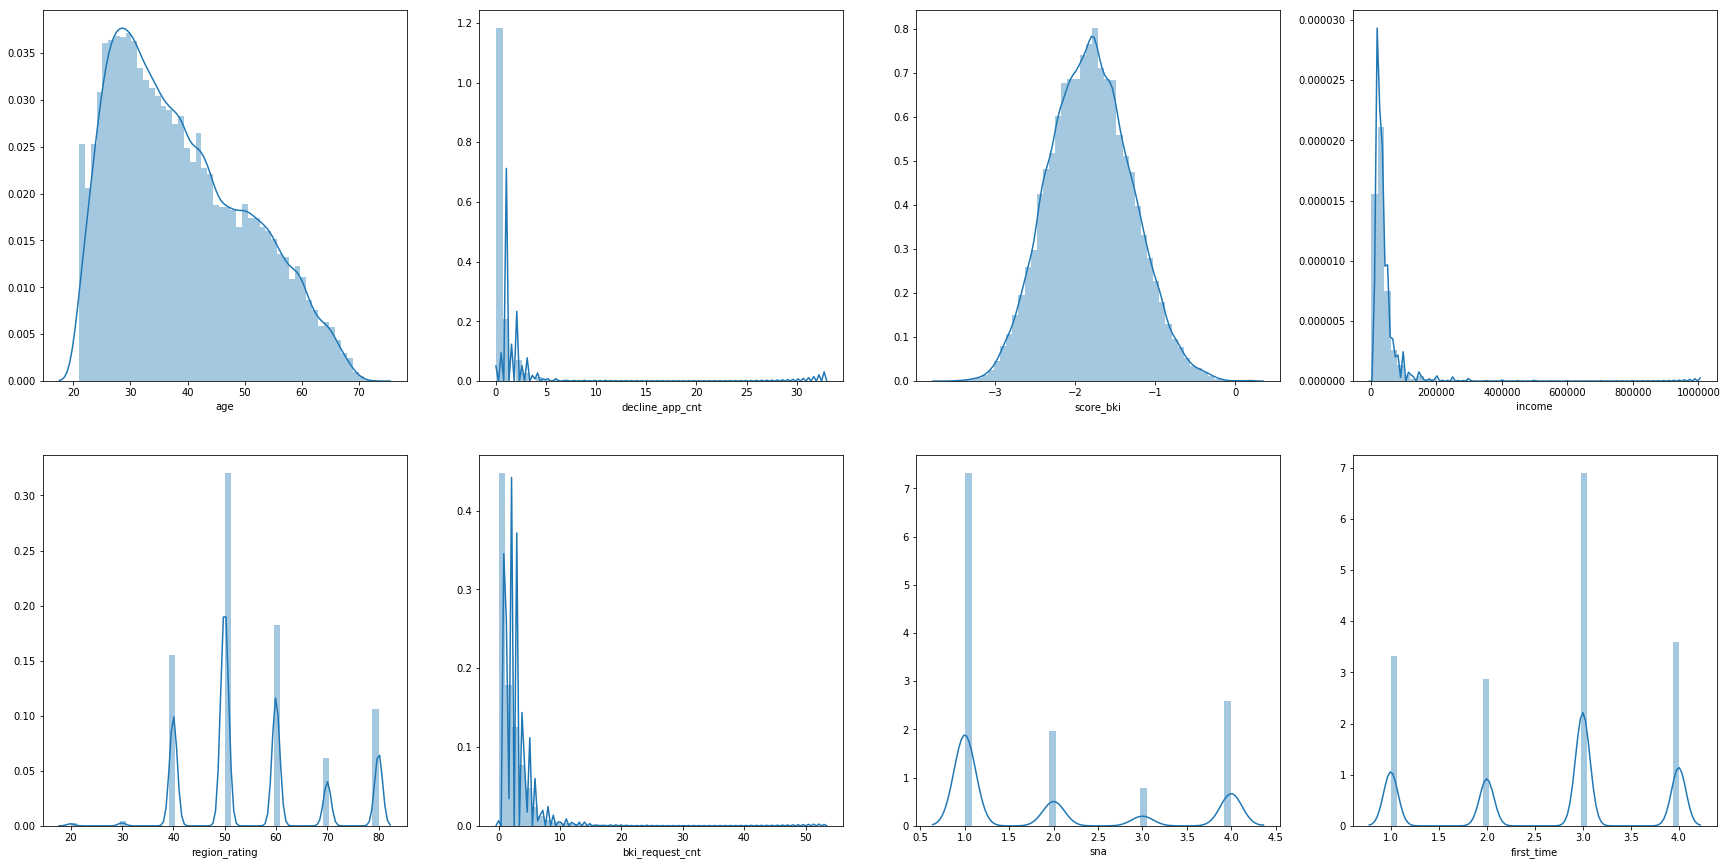

In [23]:
fig, axes = plt.subplots(2, 4, figsize = (30,15))
i = 0
for name in num_cols:
    sns.distplot(train_df[name], ax=axes.flat[i]) 
    i = i+1

Таким образом нам нужно прологарифмировать признаки income, age, decline_app_cnt, bki_request_cnt.

In [24]:
for i in ['income', 'age', 'decline_app_cnt', 'bki_request_cnt']:
    train_df[i] = np.log(train_df[i] + 1)
    test_df[i] = np.log(test_df[i] + 1)

Посмотрим на сколько коррелируют между собой числовые признаки

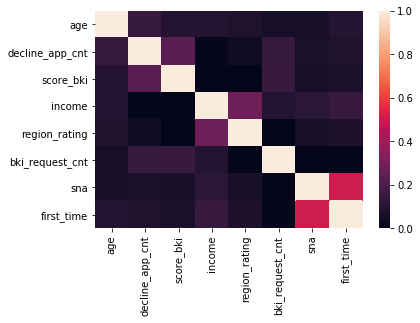

In [25]:
sns.heatmap(train_df[num_cols].corr().abs(), vmin=0, vmax=1)

Сильно коррелирующих между собой признаков нет, поэтому можем перейти дальше
Перейдем к работе с бинарными признаками.  
Для бинарных признаков мы будем использовать LabelEncoder

In [26]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train_df[column] = label_encoder.fit_transform(train_df[column])
    
# убедимся в преобразовании    
train_df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,12MAR2014,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,01FEB2014,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,23JAN2014,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,18APR2014,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


Сделаем тоже самое для тестовой выборки

In [27]:
label_encoder = LabelEncoder()

for column in bin_cols:
    test_df[column] = label_encoder.fit_transform(test_df[column])
    
# убедимся в преобразовании    
test_df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0
1,17527,24JAN2014,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0
2,75683,23MAR2014,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1
3,26883,03FEB2014,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0
4,28862,04FEB2014,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0


Преобразуем для нашей модели категориальные признаки

Для начала определимся, с признакому education.

In [28]:
train_df['education'].value_counts()

SCH    74489
GRD    35995
UGR    17562
PGR     1743
ACD      242
Name: education, dtype: int64

In [29]:
test_df['education'].value_counts()

SCH    19309
GRD    11403
UGR     4932
PGR      608
ACD       97
Name: education, dtype: int64

In [30]:
def education_to_num(education):
    if education == 'SCH':
        result = 1
    elif education == 'GRD':
        result = 2
    elif education == 'UGR':
        result = 3
    elif education == 'PGR':
        result = 4
    else:
        result = 5
    return result

In [31]:
train_df['education'] = train_df['education'].apply(education_to_num)
test_df['education'] = test_df['education'].apply(education_to_num)

Посмотрим на влияние признаков на целевую переменную

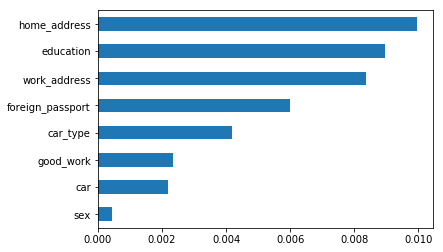

In [32]:
imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Сделать one-hot encoding для некоторых признаков

In [33]:
train_df = pd.get_dummies(train_df, columns=['education', 'work_address', 'home_address'])

In [34]:
test_df = pd.get_dummies(test_df, columns=['education', 'work_address', 'home_address'])

In [35]:
train_df.columns
cat_cols = ['education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'work_address_1', 'work_address_2', 'work_address_3',
       'home_address_1', 'home_address_2', 'home_address_3']

In [36]:
poly = PolynomialFeatures(2)
X_poly_train_df = poly.fit_transform(train_df[num_cols].values)
X_poly_test_df = poly.fit_transform(test_df[num_cols].values)

In [37]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_df[cat_cols].values)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [38]:
X_num_train_df = StandardScaler().fit_transform(X_poly_train_df)
X_num_test_df = StandardScaler().fit_transform(X_poly_test_df)

In [39]:
X_bin = train_df[bin_cols].values

In [40]:
# Объединяем

X = np.hstack([X_num_train_df, X_bin, X_cat])
Y = train_df['default'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted = model.predict(X_test)
print(accuracy_score(y_test,Y_predicted))
print(precision_score(y_test,Y_predicted))
print(recall_score(y_test,Y_predicted))
print(f1_score(y_test,Y_predicted))

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6725112469719691
0.665588473130927
0.6952849024727384
0.6801126760563381


In [42]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


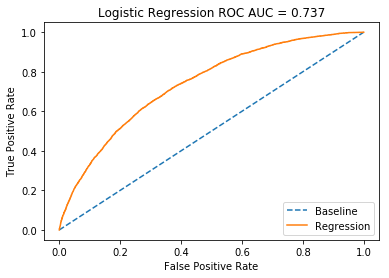

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [44]:
print(confusion_matrix(y_test, Y_predicted))

[[8436 4549]
 [3968 9054]]


Мы получили результат AUC 0.733. У нас ещё есть признак "дата заявки". Возможно на решение каким-то образом влияет день недели или месяц?

In [45]:
train_df['app_date'] = pd.to_datetime(train_df['app_date'])

In [46]:
train_df['month'] =  train_df['app_date'].dt.month
train_df['dayofweek'] =  train_df['app_date'].dt.dayofweek
train_df['day'] =  train_df['app_date'].dt.day

C:\Users\1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


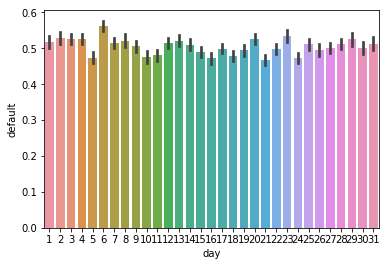

In [47]:
sns.barplot(data=train_df, x=train_df['day'], y='default')

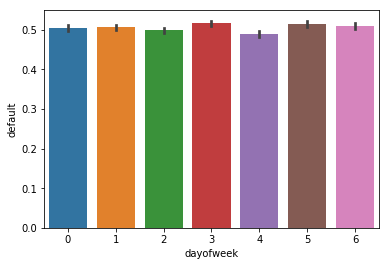

In [48]:
sns.barplot(data=train_df, x=train_df['dayofweek'], y='default')

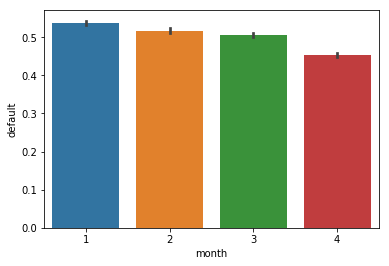

In [92]:
sns.barplot(data=train_df, x=train_df['month'], y='default')

Как мы видим из графиков, на решение банка оказывает влияние только месяц выдачи кредита

In [51]:
train_df = pd.get_dummies(train_df, columns=['month'])

KeyError: "None of [Index(['month'], dtype='object')] are in the [columns]"

In [52]:
cat_cols = ['education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'work_address_1', 'work_address_2', 'work_address_3',
       'home_address_1', 'home_address_2', 'home_address_3', 'month_1', 'month_2', 'month_3', 'month_4']

In [53]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_df[cat_cols].values)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Объединяем все признаки в одну таблицу

In [55]:
X = np.hstack([X_num_train_df, X_bin, X_cat])
Y = train_df['default'].values

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted = model.predict(X_test)
print(accuracy_score(y_test,Y_predicted))
print(precision_score(y_test,Y_predicted))
print(recall_score(y_test,Y_predicted))
print(f1_score(y_test,Y_predicted))

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6729726612065983
0.6669130145591604
0.6929811088926432
0.6796972093548752


C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


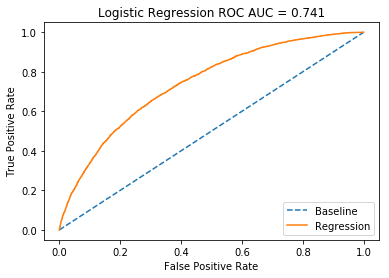

In [57]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [58]:
print(confusion_matrix(y_test, Y_predicted))

[[8478 4507]
 [3998 9024]]


Наш показатель AUC увеличился незначительно - на 0.004 и recall на 0.01

In [ ]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [ ]:
Обучаем модель с учетом полученных гиперпараметро

In [ ]:
model = LogisticRegression(penalty='l1', C=21.544346900318832, max_iter=800)
model.fit(X_train, y_train)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


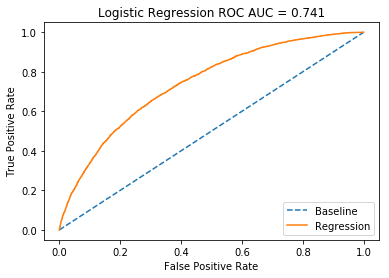

In [59]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted = model.predict(X_test)
print(accuracy_score(y_test,Y_predicted))
print(precision_score(y_test,Y_predicted))
print(recall_score(y_test,Y_predicted))
print(f1_score(y_test,Y_predicted))

In [ ]:
print(confusion_matrix(y_test, Y_predicted))

Создаем таблицу с тестовой выборкой и высчитываем для её значение default

In [68]:
test_df['app_date'] = pd.to_datetime(test_df['app_date'])
test_df['month'] =  test_df['app_date'].dt.month
test_df = pd.get_dummies(test_df, columns=['month'])

In [69]:
X_cat_test_df = OneHotEncoder(sparse = False).fit_transform(test_df[cat_cols].values)
X_bin_test_df = test_df[bin_cols].values
test_final_df = np.hstack([X_num_test_df, X_bin_test_df, X_cat_test_df])
probs = model.predict_proba(test_final_df)
probs = probs[:, 1]

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Получили итоговый результат, который пойдет в submission

In [70]:
ids = test_df['client_id']
submission = pd.DataFrame({'client_id': ids,
                              'default': probs})
submission.to_csv('submission.csv', index=False)

submission.head(10)

,client_id,default
0,74835,0.267697
1,17527,0.857034
2,75683,0.410646
3,26883,0.386675
4,28862,0.118381
5,99881,0.585282
6,26630,0.836027
7,79934,0.333027
8,16605,0.148826
9,105449,0.126051
